#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Требование заказчика - значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Работу будем проводить следующим образом:

1. Загрузим данные и выполним их ресемплирование по одному часу.
2. Проанализируем данные.
3. Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных.
4. Проверим данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Зависимость-от-месяца" data-toc-modified-id="Зависимость-от-месяца-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Зависимость от месяца</a></span></li><li><span><a href="#Зависимость-от-дня-недели" data-toc-modified-id="Зависимость-от-дня-недели-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Зависимость от дня недели</a></span></li><li><span><a href="#Зависимость-от-часа" data-toc-modified-id="Зависимость-от-часа-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Зависимость от часа</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель--календарных-признаков" data-toc-modified-id="Модель--календарных-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель  календарных признаков</a></span></li><li><span><a href="#Модель-отстающих-значений" data-toc-modified-id="Модель-отстающих-значений-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель отстающих значений</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Модель-календарных-признаков" data-toc-modified-id="Модель-календарных-признаков-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Модель календарных признаков</a></span></li><li><span><a href="#Модель-отстающих-значений" data-toc-modified-id="Модель-отстающих-значений-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Модель отстающих значений</a></span></li></ul></li><li><span><a href="#Построение-объединенной-модели" data-toc-modified-id="Построение-объединенной-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Построение объединенной модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Подготовка

Загрузим необходимые библиотеки.

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Загрузим датасет, сконвертируем дату в формат `datetime`, сделаем его индексом и посмотрим на первые 5 строк.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Видно, что в качестве индексов в данных используется дата и время. 

В колонке `num_orders` находится количество заказов.

Посмотрим информацию и датасете.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В датасете представлены данные с марта 2018 по август 2018.

Проведем ресемплирование данных по 1 часу, суммируя количество заказов. Посмотрим на первые 5 строк.

In [4]:
data_1h = data.resample('H').sum()
data_1h.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод:**

На данном этапе:
- Было проведено ознакомление с данными.
- Определено, что в датасете представлены данные с марта 2018 по август 2018.
- Было проведено ресемплирование данных по 1 часу.

## Анализ

Проанализируем, как меняется спрос в зависимости от различных параметров.

### Зависимость от месяца

Посмотрим средний спрос на такси в зависимости от месяца.

<AxesSubplot:xlabel='datetime'>

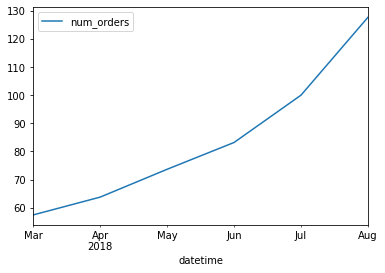

In [5]:
temp_data = data_1h.copy()
temp_data.resample('M').mean().plot(y='num_orders')

Видно, что спрос на такси с марта по август только растет.

### Зависимость от дня недели

Теперь посмотрим на спрос в зависимости от дня недели. Для этого создадим новый столбец и сгруппируем данные по нему.

<AxesSubplot:xlabel='day_of_week'>

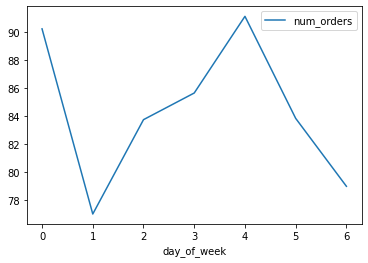

In [6]:
temp_data['day_of_week'] = data_1h.index.dayofweek
temp_data.groupby('day_of_week').mean().plot(y='num_orders')

Тренд выглядит следующим образом: в понедельник спрос на такси большой, но он падает ко вторнику. Со вторника до пятницы спрос растет и после достижения пика в пятницу начинает падать в выходные.

### Зависимость от часа

Теперь построим зависимость от времени дня.

<AxesSubplot:xlabel='H'>

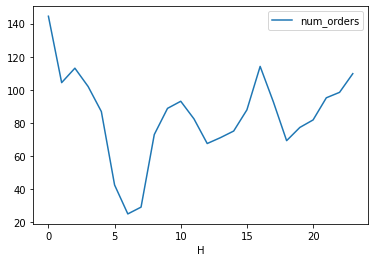

In [7]:
temp_data['H'] = data_1h.index.hour
temp_data.groupby('H').mean().plot(y='num_orders')

Видно, что наибольший спрос на такси наблюдается в 12 часов ночи. Затем спрос падает до 6 утра. Ближе к началу рабочегоя дня, около 9-10 утра, спрос опять растет. После этого он начинает падать и растет опять к 16 часам (что странно, куда люди едут до конца рабочего дня). После окончания рабочего дня (около 19 часов) спрос опять наичнает расти.

**Вывод:**

На данном этапе был проведен анализ полученных данных о количестве заказов такси. Было показано:
- Спрос с марта по август растет.
- В зависимости от дня недели наблюдается различный спрос на такси.
- В течение дня спрос на такси так же меняется.

## Обучение

Обучим несколько моделей.

### Модель  календарных признаков

Первая модель будет предсказывать количество заказов по календарным признакам. Добавим соответствующие столбцы в датасет и посмотрим на первые 5 строк.

In [8]:
data_cal = data_1h.copy()

data_cal['dayofweek'] = data_1h.index.dayofweek
data_cal['hour'] = data_1h.index.hour

data_cal.head()

,num_orders,dayofweek,hour
datetime,,,
2018-03-01 00:00:00,124,3,0
2018-03-01 01:00:00,85,3,1
2018-03-01 02:00:00,71,3,2
2018-03-01 03:00:00,66,3,3
2018-03-01 04:00:00,43,3,4


Теперь разобьем наш датасет на признаки и целевую переменную.

In [9]:
X_cal = data_cal.drop(columns='num_orders')
y_cal = data_cal['num_orders']

Теперь разобьем данные на тренировочную и тестовую выборки в соотношении 90/10.

In [10]:
X_cal_train, X_cal_test, y_cal_train, y_cal_test = train_test_split(X_cal, y_cal, 
                                                                    shuffle=False, 
                                                                    test_size=0.1)

Обучим модель линейной регрессии и посчитаем RMSE. Напишем соответствующую функцию.

In [11]:
def fit_time_series(X, y):
    lr = LinearRegression()
    lr.fit(X, y)

    pred = lr.predict(X)

    rmse = mean_squared_error(y, pred) ** 0.5
    return rmse, lr

Применим функцию для первой модели.

In [12]:
rmse_cal, lr_cal = fit_time_series(X_cal_train, y_cal_train)
print(f'RMSE модели на тренировочной выборке составило {rmse_cal:.2f}')

RMSE модели на тренировочной выборке составило 38.66


### Модель отстающих значений

Теперь построим датасет по остающим значениям. Создадим 10 отстающих значений и посмотрим на первые 10 строк.

In [13]:
data_lag = data_1h.copy()

max_lag = 10

for lag in range(1, max_lag + 1):
    data_lag[f'lag_{lag}'] = data_lag['num_orders'].shift(lag)

data_lag.head(10)    

,num_orders,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 08:00:00,34,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN


Теперь разобьем наш датасет на признаки и целевую переменную.

In [14]:
X_lag = data_lag.dropna().drop(columns='num_orders').dropna()
y_lag = data_lag.dropna()['num_orders']

Теперь разобьем данные на тренировочную и тестовую выборки в соотношении 90/10.

In [15]:
X_lag_train, X_lag_test, y_lag_train, y_lag_test = train_test_split(X_lag, y_lag, 
                                                                    shuffle=False, 
                                                                    test_size=0.1)

Обучим модель линейной регрессии и посчитаем RMSE.

In [16]:
rmse_lag, lr_lag = fit_time_series(X_lag_train, y_lag_train)
print(f'RMSE модели на тренировочной выборке составило {rmse_lag:.2f}')

RMSE модели на тренировочной выборке составило 31.27


**Вывод:**

На данном этапе было построено две модели:
- Первая предсказывает значение по календарным характеристикам. Значение метрики RMSE данной модели на тренировочной выборке составило 38.66.
- Вторая модель использует отстающие значения для предсказаний. Значение метрики RMSE составило 30.62.

## Тестирование

Теперь проверим метрики для обоих моделей на тестовых данных.

### Модель календарных признаков

In [17]:
print(f'RMSE модели на тестовой выборке составило \
{mean_squared_error(y_cal_test, lr_cal.predict(X_cal_test)) ** 0.5:.2f}')

RMSE модели на тестовой выборке составило 84.76


Значение RMSE у нас не попадает в требования заказчика. Сделаем визуализацию, которая покажет, насколько сходятся наши данные. Напишем соответствующую функцию.

In [18]:
def plot_timeseries_score(model, X, y, days):
    predictions = model.predict(X)
    temp_df = pd.DataFrame({'true':y, 'predictions':predictions}).set_index(y.index)
    temp_df[:temp_df.index[0] + pd.DateOffset(days=days)].plot()

Посмотрим на предсказания и реальные значения для тестовой выборки у модели.

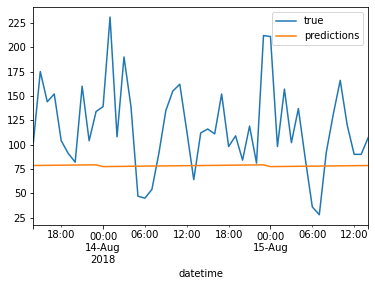

In [19]:
plot_timeseries_score(lr_cal, X_cal_test, y_cal_test, 2)

Видно, что модель просто провела линию между реальными значениями. Такая модель точно не подходит для предсказаний.

### Модель отстающих значений

In [20]:
print(f'RMSE модели на тестовой выборке составило \
{mean_squared_error(y_lag_test, lr_lag.predict(X_lag_test)) ** 0.5:.2f}')

RMSE модели на тестовой выборке составило 54.66


Построим график и для этой модели.

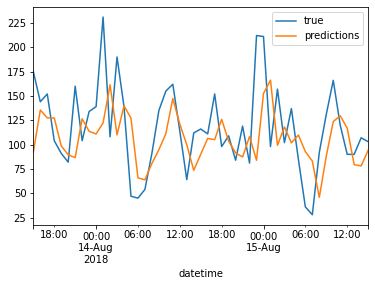

In [21]:
plot_timeseries_score(lr_lag, X_lag_test, y_lag_test, 2)

Видно, что в данном случае модель предсказывает значения уже лучше, чем модель с календарными признаками. Однако, RMSE все же не лежит в нужных нам пределах.

**Вывод:**

Обе модели показали недопустимые значения RMSE: 84.76 и 54.66, соответственно.

На следующем этапе построим объединенную модель, которая содержит в себе различные признаки.

## Построение объединенной модели

Построим модель, которая содержит как календарные признаки, так и отстающие значения, так и скользящие средние.

In [235]:
data_cl = data_1h.copy()

data_cl['dayofweek'] = data_1h.index.dayofweek
data_cl['hour'] = data_1h.index.hour

max_lag = 24

for lag in range(1, max_lag + 1):
    data_cl[f'lag_{lag}'] = data_cl['num_orders'].shift(lag)

data_cl['rolling_mean'] = data_cl['num_orders'].shift().rolling(24).mean()
    
data_cl.head(10)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,3,8,15.0,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Видно, что признаки мы создали. Перейдем к обучению. Создадим соответствующие датасеты.

In [236]:
X_cl = data_cl.dropna().drop(columns='num_orders').dropna()
y_cl = data_cl.dropna()['num_orders']

Теперь разобьем данные на тренировочную и тестовую выборки в соотношении 90/10.

In [237]:
X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(X_cl, y_cl, 
                                                                    shuffle=False, 
                                                                    test_size=0.1)

Обучим модель линейной регрессии и посчитаем RMSE.

In [238]:
rmse_cl, lr_cl = fit_time_series(X_cl_train, y_cl_train)
print(f'RMSE модели на тренировочной выборке составило {rmse_cl:.2f}')

RMSE модели на тренировочной выборке составило 25.84


Проверим тестовую выборку.

In [239]:
print(f'RMSE модели на тестовой выборке составило \
{mean_squared_error(y_cl_test, lr_cl.predict(X_cl_test)) ** 0.5:.2f}')

RMSE модели на тестовой выборке составило 45.22


Видно, что с точки зрения RMSE, данная модель предсказывает значения лучше, чем модель с только календарными признаками и только отстающая.

Построим график и для этой модели.

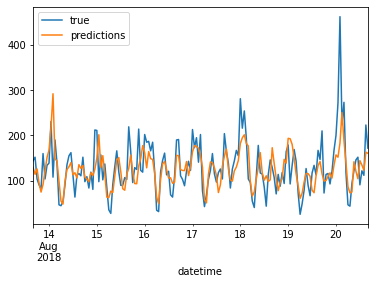

In [240]:
plot_timeseries_score(lr_cl, X_cl_test, y_cl_test, 7)

Видно, что в целом модель может предсказывать значения достаточно близко к реальным. RMSE модели составило 45.22, что ниже необходимых 48.

## Общий вывод

В данном проекте были построены модели, предсказывающие спрос на такси:
- Данные были загружены и проанализированы.
- Построена модель, предсказывающая спрос по календарным признакам. RMSE данной модели на тестовой выборке составило 84.76.
- Построена модель, предсказывающая спрос по отстающим значениям. RMSE данной модели на тестовой выборке составило 54.66.
- Модель, которая бы объединяла в себе все признаки: как календарные, так и отстающие, так и скользящие средниее, показала лучший результат с точки зрения RMSE - 45.22.